## K - means clustering

Là một thuật toán học không giám sát (unsupervisod learning)

Cho một tập dữ liệu không có đánh nhãn, biết tập dữ liệu này có $k$ nhóm (cluster). Nhiệm vụ là nhóm các dữ liệu có liên quan với nhau thành một cluster,


### Mô hình toán học

Tập dữ liệu
$$
\mathbf{X} 
=
\begin{bmatrix}
x_{11}\space ...\space x_{1d} \\
  ... \space ...\space ... \\
x_{N1}\space ...\space x_{Nd}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{x}_1 \\
  ...  \\
\mathbf{x}_N
\end{bmatrix}
$$

Ta đã biết số lượng nhóm, mỗi nhóm sẽ có một điểm đại diện, gọi là centroid, centroid của cluster $j$ là $\mathbf{m_j}$, $\mathbf{m_j} = [m_1\space ...\space m_d]$, tập các centroid:
$$
\mathbf{M} 
=
\begin{bmatrix}
\mathbf{m}_1 \\
  ...  \\
\mathbf{m}_k
\end{bmatrix}
$$

Khi $\mathbf{x}_i$ thuộc vào nhóm $j$, ta biểu diễn điều này bằng $\mathbf{y}_i = [y_1\space ... \space y_k]$ với $y_j = 1$ và $y_i = 0$ với mọi $i \neq j$, ta có tập các label:
$$
\mathbf{Y}
=
\begin{bmatrix}
\mathbf{y}_1 \\
  ...  \\
\mathbf{y}_N
\end{bmatrix}
$$

Khi đó, mục tiêu của chúng ta là đi tìm $\mathbf{M}$ và $\mathbf{Y}$


#### **Loss function**
$$
\mathcal{L}(\mathbf{M}, \mathbf{Y}) 
= \sum_{i=1}^N{\|\mathbf{x}_i - \mathbf{y}_i\mathbf{M}\|_2^2} \\
= \sum_{i=1}^N{(\mathbf{x}_i - \mathbf{y}_i\mathbf{M})(\mathbf{x}_i - \mathbf{y}_i\mathbf{M})^T} \\
= \sum_{i=1}^N{(\|\mathbf{x}_i\|_2^2 + \|\mathbf{y}_i\mathbf{M}\|_2^2 - 2\mathbf{y}_i\mathbf{M}\mathbf{x}_i^T)} \\
= \sum_{i=1}^N{\|\mathbf{x}_i\|_2^2} + \sum_{i=1}^N{\|\mathbf{y}_i\mathbf{M}\|_2^2} - 2\sum_{i=1}^N{\mathbf{y}_i\mathbf{M}\mathbf{x}_i^T} \\
= \|\mathbf{X}\|_F^2 + \|\mathbf{YM}\|_F^2 - 2\text{trace}(\mathbf{YMX^T})
$$

Tìm đạo hàm riêng theo $\mathbf{M}$ và $\mathbf{Y}$

$$
\nabla _\mathbf{M} \mathcal{L} = \nabla _\mathbf{M}(\|\mathbf{X}\|_F^2) + \nabla _\mathbf{M}(\|\mathbf{YM}\|_F^2) + 2\nabla_\mathbf{M}(\text{trace}(\mathbf{YMX^T})) 
= 2\mathbf{Y^TYM} - 2\mathbf{Y^TX}
$$

$$
\nabla _\mathbf{Y} \mathcal{L} = \nabla _\mathbf{Y}(\|\mathbf{X}\|_F^2) + \nabla _\mathbf{Y}(\|\mathbf{YM}\|_F^2) + 2\nabla_\mathbf{Y}(\text{trace}(\mathbf{YMX^T})) 
= 2\mathbf{YMM^T} - 2\mathbf{XM^T}
$$

Giải phương trình đạo hàm riêng bằng $0$:
$$
\begin{cases}
\nabla _\mathbf{M} \mathcal{L} = 0 \\
\nabla _\mathbf{Y} \mathcal{L} = 0
\end{cases}
\Leftrightarrow
\begin{cases}
\mathbf{M} = (\mathbf{Y^TY})^+\mathbf{Y^TX} \space (1)\\
\mathbf{Y} = \mathbf{XM^T}(\mathbf{MM^T})^+\space (2)
\end{cases}
\space (*)
$$

Phương trình $(*)$ rất khó giải trực tiếp, ta có thể sử dụng thuật toán sau để giải
- B1. Khởi tạo ngẫu nhiên $\mathbf{M}$
- B2. Sử dụng **(2)** để tìm $\mathbf{Y}$
- B3. Lặp lại các bước trên cho tới khi nghiệm không có sự thay đổi

Tuy nhiên, công thức $(2)$ trong lời giải trên chưa thỏa mãn ràng buộc $\mathbf{Y}$ phải là ma trận one-hot. 
Ta cần sử lại công thức $(2)$:
$$
\mathbf{Y}
=
\begin{bmatrix}
\mathbf{y_1} \\
... \\
\mathbf{y_N}
\end{bmatrix},
\mathbf{y_i} = [y_{i1},\space ...,\space y_{ik}],\space 
y_{ij} = 
\begin{cases}
\text{1, Nếu } j = \argmin _{j=\bar{1,K}} (\|\mathbf{x_i} - \mathbf{m_j}\|_2^2) \\
\text{0, Còn lại}
\end{cases} 
$$



### Triển khai

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class Model:
    def __init__(self, n_clusters):
        self.k = n_clusters
        self.cluster_centers_ = None
        self.Y = None
    
    # Khởi tạo ngẫu nhiên các Centroid 
    def kmeans_init_centroids(self, X):
        self.cluster_centers_ = X[np.random.choice(X.shape[0], self.k, replace=False)]

    # Tìm Y khi cố định M
    def kmeans_assign_labels(self, X):
        cluster_indices = self.predict(X)
        N = X.shape[0]
        K = self.cluster_centers_.shape[0]
        Y_one_hot = np.zeros((N, K))
        Y_one_hot[np.arange(N), cluster_indices] = 1
        self.Y = Y_one_hot
        return self.Y

    # Tìm M khi cố định Y
    def kmeans_update_centroids(self, X):
        self.cluster_centers_ = np.linalg.pinv(self.Y.T @ self.Y) @ (self.Y.T @ X)
        return self.cluster_centers_
    
    # Kiểm tra điều kiện dừng
    def has_converged(self, centroids, new_centroids, tol=1e-6):
        return np.allclose(centroids, new_centroids, atol=tol)
    
    def fit(self, X):
        self.kmeans_init_centroids(X)
        centroid = [self.cluster_centers_]
        labels = []
        it = 0
        while True:
            labels.append(self.kmeans_assign_labels(X))
            new_centroids = self.kmeans_update_centroids(X)
            if self.has_converged(centroid[-1], new_centroids):
                break
            centroid.append(new_centroids)
            it += 1
        return it
    
    def predict(self, X):
        D = cdist(X, self.cluster_centers_)
        return np.argmin(D, axis=1)

In [71]:
def kmeans_display(X, centroids):
    x_M = centroids[:, 0]
    y_M = centroids[:, 1]
    x_X = X[:, 0]
    y_X = X[:, 1]
    plt.figure(figsize=[6, 6])
    plt.scatter(x_X, y_X, color='yellow', marker='o')
    plt.scatter(x_M, y_M, color='blue', marker='^')
    plt.show()

### Tạo dữ liệu kiểm thử

In [72]:
means = [[3, 2], [8, 3], [3, 6]]
cov   = [[1, 0], [0, 1]]
N  = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
X  = np.concatenate((X0, X1, X2), axis = 0)

K  = 3 
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

#### Sử dụng Model được triển khai bên trên

Centers found:
[[3.04767588 1.98170822]
 [7.98601149 2.98256928]
 [3.02859688 6.01872084]]


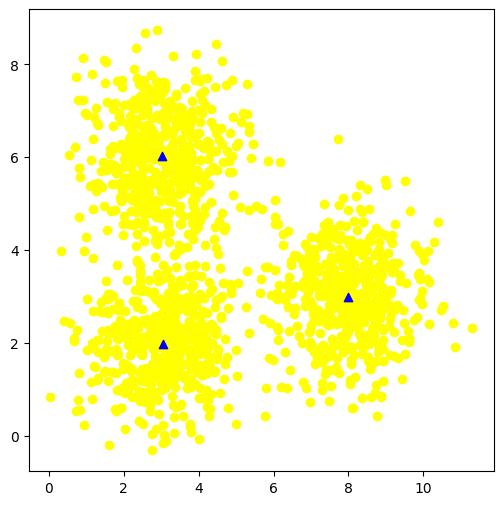

In [73]:
model = Model(K)
model.fit(X)
print("Centers found:")
print(model.cluster_centers_)
kmeans_display(X, model.cluster_centers_)

### Sử dụng Model trong Scikit-learn

Centers found by scikit-learn:
[[7.98601149 2.98256928]
 [3.02859688 6.01872084]
 [3.04767588 1.98170822]]


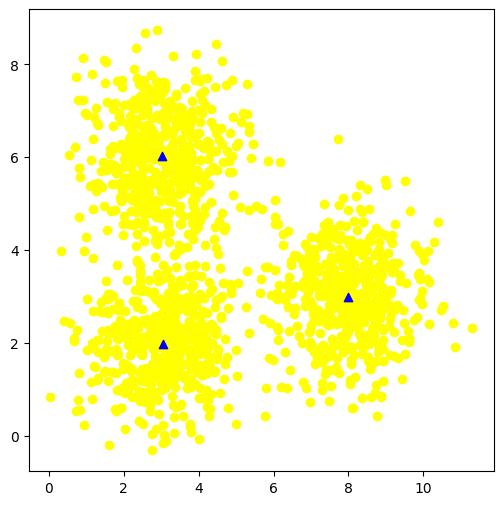

In [74]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, random_state=0).fit(X)
print("Centers found by scikit-learn:")
print(model.cluster_centers_)
pred_label = model.predict(X)
kmeans_display(X, model.cluster_centers_)

## Phân loại chữ số viết tay

Có một tập dữ liệu số viết tay, cần phân loại thành các nhóm số

In [75]:
def imshow(images, labels):
    plt.figure(figsize=[10, 2])
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(str(labels[i]), fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [76]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target.astype(int)

print("Shape of MNIST data:", X.shape)  # (70000, 784)

# Tải dữ liệu MNIST
mnist  = fetch_openml('mnist_784', version=1, as_frame=False)
Images = mnist.data
Labels = mnist.target.astype(int)

# Tập dữ liệu train
N = 10000
np.random.seed(42)
indices = np.random.choice(Images.shape[0], N, replace=False)
X = Images[indices]
y = Labels[indices]

# Tập dữ liệu để dự đoán
indices = np.random.choice(Images.shape[0], 10, replace=False)
X_pred  = Images[indices]
Y_label = Labels[indices]

Shape of MNIST data: (70000, 784)


#### Sử dụng Model triển khai bên trên

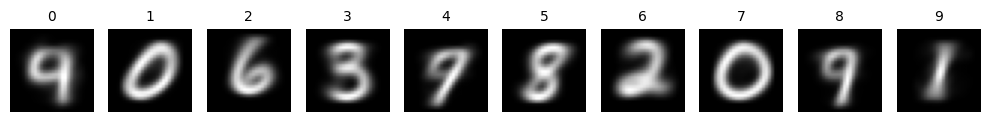

In [77]:
kmeans = Model(n_clusters=10)
kmeans.fit(Images)
labels = kmeans.predict(kmeans.cluster_centers_)
imshow(kmeans.cluster_centers_, labels)

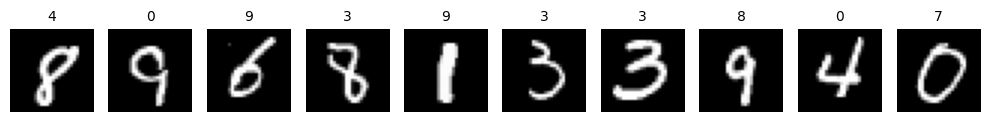

In [78]:
labels = kmeans.predict(X_pred)
imshow(X_pred, labels)

#### Sử dụng Scikit-learn

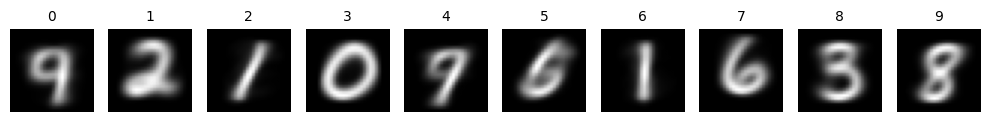

In [79]:
kmeans = KMeans(n_clusters=10).fit(Images)
labels = kmeans.predict(kmeans.cluster_centers_)
imshow(kmeans.cluster_centers_, labels)

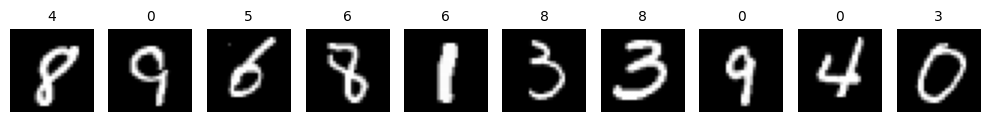

In [80]:
labels = kmeans.predict(X_pred)
imshow(X_pred, labels)

## Tách vật thể trong ảnh (Object Segmentaion)

Một bức ảnh có một vài vật thể, cần phân loại số vật thể trong ảnh


In [81]:
img = cv2.imread('../opencv/images/girl.jpg', cv2.IMREAD_COLOR_RGB)
# Trải phẳng dữ liệu
X = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

#### Model triển khai bên trên

In [82]:
model = Model(n_clusters=7)
model.fit(X)
labels = model.predict(X)
dst1 = np.uint8(np.array(model.cluster_centers_[labels])).reshape((img.shape[0], img.shape[1], img.shape[2]))

#### Model của Scikit-learn

In [83]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
labels = kmeans.predict(X)
dst2 = np.uint8(np.array(kmeans.cluster_centers_[labels])).reshape((img.shape[0], img.shape[1], img.shape[2]))

#### Kết quả

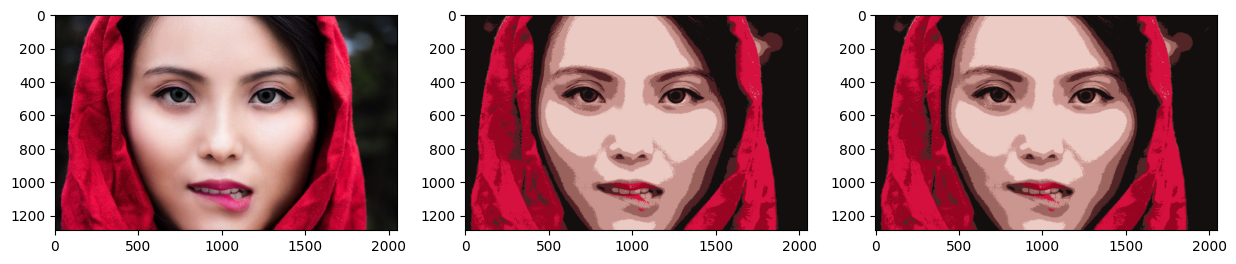

In [84]:
plt.figure(figsize=[15, 5])
plt.subplot(131); plt.imshow(img)
plt.subplot(132); plt.imshow(dst1)
plt.subplot(133); plt.imshow(dst2)

## Thảo luận